# Getting Started with Pipeline

## What is `Pipeline` in Towhee

`Pipeline` is a pythonic computation framework for unstructured data in machine learning and data science. It provides a [method-chaining style API](https://towhee.readthedocs.io/en/main/index.html) that makes it easier for a data scientist or researcher to assemble a data processing pipeline.

- Pythonic Method-Chaining Style API: Designed to behave as a python list or iterator, `Pipeline` is easy to understand for python users and is compatible with most popular data science toolkits. Function/Operator invocations can be chained one after another, making your code clean and fluent.

- Feature-Rich Operator Repository: There are various pre-defined operators On the towhee hub, which cover the most popular deep learning models in computer vision, NLP, and voice processing. Using these operators in the data processing pipeline can significantly accelerate your work.

## Preparation 

Before getting started, we need to install the dependencies and download the test data.

### Install dependencies

First we need to install dependencies such as towhee, pandas.

In [ ]:
! python -m pip install -q towhee

## Create a `Pipeline`

This is the simplest example of `Pipeline`, it recieves the input and outputs the data immediately. We start with this `Pipeline` to illustrate the structure of a `Pipeline`, a `Pieline` should at least contain a `input` and a `output` node.

In [1]:
from towhee import pipe
from towhee.datacollection import DataCollection


p = (
	pipe.input('num')
		.output('num')
)

res = p(1)
DataCollection(res).show()

num
1


## Nodes

### Map

Usage:
	
	map(input_schema, output_schema, fn, config=None)

Map node get the specified data by input_schema from each element as input, apply it to a function, then specify the schema of output as output_schema.

<img src="map_node.png" width="600px">

In [2]:
p = (
	pipe.input('num')
		.map('num', 'num', lambda x: x * 2)
		.output('num')
)

res = p(1)
DataCollection(res).show()


num
2


### Flat Map

Usage:

	flat_map(input_schema, output_schema, fn, config=None)

Flat Map get the specified data by input_schema from each element as input, apply it to a function, then flatten the results, and specify the schema of output as output_schema.

<img src="flat_map_node.png" width="600px">

In [3]:
p = (
	pipe.input('num')
		.flat_map('num', 'num', lambda x: [i * 2 for i in x])
		.output('num')
)

res = p([1, 2, 3])
DataCollection(res).show()

num
2
4
6


### Filter

Usage:

	filter(input_schema, output_schema, filter_columns, fn, config=None)

Filter only select elements that satisfy the predicate, it will check the function with filter_columns as input. And the input_schema and out_schema are the data before and after the filter node, so their lengths are required to be equal.

<img src="filter_node.png" width="600px">

In [4]:
p = (
	pipe.input('num')
		.flat_map('num', 'num', lambda x: [i * 2 for i in x])
		.filter('num', 'num', 'num', lambda x: x > 2)
		.output('num')
)

res = p([1, 2, 3])
DataCollection(res).show()

num
4
6


### Window

Usage:

	window(input_schema, output_schema, size, step, fn, config=None)

Assign all the elements into windows of finite size, over which to apply computations(fn). The size of each window is configured by the size parameter, the step parameter controls how frequently a window is started. 

<img src="window_node.png" width="600px">

In [5]:
p = (
	pipe.input('num')
		.flat_map('num', 'num', lambda x: [i * 2 for i in x])
		.window('num', 'nums', 2, 1, lambda x: [i * 2 for i in x])
		.output('num', 'nums')
)

res = p([1, 2, 3, 4])
DataCollection(res).show()

num,nums
2,"[4,8] len=2"
4,"[8,12] len=2"
6,"[12,16] len=2"
8,[16] len=1


### Time Window

Usage:

	time_window(input_schema, output_schema, timestamp_col, size, step, fn, config=None)

Assign all the elements into time windows of finite size based on the timestamp_col column, over which we can apply computations(fn). The time interval of each time window is configured by the size parameter, and the step parameter controls the time frequency at which a time window starts. 

<img src="time_window_node.png" width="600px">

In [6]:
p = (
	pipe.input('num', 'timestamp')
		.flat_map(('num', 'timestamp'), ('num', 'timestamp'), lambda x,y: [(i, j) for i, j in zip(x, y)])
		.time_window('num', 'nums', 'timestamp', 2, 1, lambda x: x)
		.output('num', 'timestamp', 'nums')
)

res = p([1, 2, 3, 4, 5], [0, 1000, 2000, 4000, 5000])
DataCollection(res).show()

num,timestamp,nums
1,0,"[1,2] len=2"
2,1000,"[2,3] len=2"
3,2000,[3] len=1
4,4000,[4] len=1
5,5000,"[4,5] len=2"


### Window All

Usage:

	window_all(input_schema, output_schema, fn, config=None)

Assign all the elements into one window, over which we can apply computations(fn).

<img src="window_all.png" width="600px">

In [7]:
p = (
	pipe.input('num')
		.flat_map('num', 'num', lambda x: [i * 2 for i in x])
		.window_all('num', 'nums', lambda x: [i * 2 for i in x])
		.output('num', 'nums')
)

res = p([1, 2, 3, 4])
DataCollection(res).show()

num,nums
2,"[4,8,12,16] len=4"
4,"[4,8,12,16] len=4"
6,"[4,8,12,16] len=4"
8,"[4,8,12,16] len=4"


### Concat

Usage:

	concat(*pipeline)

Concat one or more pipelines to the existing pipeline and update all data from each pipeline.

<img src="concat_node.png" width="600px">

In [8]:
from towhee import pipe
pipe0 = (
	pipe.input('a', 'b', 'c')
)
pipe1 = (
	pipe0.map('a', 'd', lambda x: x+1)
)

pipe2 = (
	pipe0.map(('b', 'c'), 'e', lambda x, y: x - y)
)

pipe3 = pipe2.concat(pipe1).output('a', 'b', 'c', 'd', 'e')

res = pipe3(1, 2, 3)
DataCollection(res).show()

a,b,c,d,e
1,2,3,2,-1


## Towhee Operator

Operators are the basic units of computation that can be applied to the elements within a DataCollection. There are many predefined Operators on the [Towhee hub](https://towhee.io/operators?limit=30&page=1), including popular deep learning models ranging from computer vision to natural language processing.

We can load an Operator from the Towhee hub as following:

	ops.namespace.operator_name(**kws, *args)

In [9]:
from towhee import ops
op = ops.image_decode.cv2()
img = op('1.jpg')

### Custom Operator

It is also easy to define custom operators with standard Python functions with `towhee.register`:

In [10]:
from towhee import register

@register
def add_1(x):
    return x+1

ops.add_1()(2)

3

If the operator needs additional initializations arguments, it can be defined as a class:

In [11]:
@register
class add_x:
    def __init__(self, x):
        self._x = x
    def __call__(self, y):
        return self._x + y

ops.add_x(x=1)(2)

3

### Run Operator with `Pipeline`

When an operator is uploaded to the Towhee hub or registered with @register, we can call the operato directly on a Pipeline:

url,image
1.jpg,

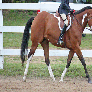

num,processed_num
1,3


In [12]:
p = (
	pipe.input('url')
		.map('url', 'image', ops.image_decode.cv2('rgb'))
		.output('url', 'image')
)
DataCollection(p('1.jpg')).show()

p = (
	pipe.input('num')
		.map('num', 'processed_num', ops.add_x(x=2))
		.output('num', 'processed_num')
)
DataCollection(p(1)).show()

## Complete Example

Here we show a complete example of towhee `Pipeline` that implements a image embedding task

urls,images,embeddings
1.jpg,,"[0.010864214, 0.0, 0.2484118, ...] shape=(2048,)"
2.jpg,,"[0.0, 0.0, 0.0, ...] shape=(2048,)"
3.jpg,,"[0.0002684289, 0.0, 0.17076984, ...] shape=(2048,)"

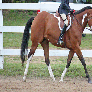
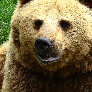
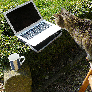

In [13]:
emb_pipe = (
	pipe.input('urls')
		.flat_map('urls', 'urls', lambda x: x)
		.map('urls', 'images', ops.image_decode.cv2('rgb'))
		.map('images', 'embeddings', ops.image_embedding.timm(model_name='resnet50'))
		.output('urls', 'images', 'embeddings')
)

res = emb_pipe(['1.jpg', '2.jpg', '3.jpg'])
DataCollection(res).show()